Step 1: Advanced Analysis & Cohort Breakdown
This step expands on regular transactional insights and introduces user lifecycle analysis for strategic understanding.

Regular Analyses
Performed across all cleaned transaction files:

     Merchant Category Analysis: Aggregated transaction count and total amount per merchant_category.

     Day of Week Trends: Evaluated weekly behavioral patterns in transactions.

     Hourly by Category: Captured hour-wise activity segmented by merchant category.

     Geography Breakdown: Mapped transaction volume and value by country-city combinations.

     Monthly Trends: Tracked monthly transaction progression for overall business pulse.

All outputs saved in: advanced_analysis/
(e.g., category_analysis.csv, monthly_analysis.csv)


Cohort Analysis (User Retention & Behavior)
Enabled by tracking each user’s first transaction month:

    Cohort Identification: Assigned each user_id to a cohort based on their first active month.

    Monthly Lifespan Tracking: Calculated months_since_first to understand user behavior over time.

    Aggregation: Grouped by cohort and months_since_first to compute:

        Unique user count

        Transaction count

        Total transaction amount

Outputs:
    cohort_retention.csv: Absolute user retention per cohort

    cohort_retention_percent.csv: Percentage retention normalized by cohort size

    cohort_transaction_count.csv: Transaction volume per cohort-month

    cohort_spending.csv: Total amount spent per cohort-month

    cohort_avg_spending.csv: Average spend per retained user

These files enable visualization of user retention, loyalty, and spending behavior across lifecycle stages.



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime

# Directories
CLEAN_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data"
ANALYSIS_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\advanced_analysis"
VISUALIZATION_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\visualizations"
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

# Initialize containers for regular analysis
category_stats = defaultdict(lambda: {"count": 0, "amount": 0})
dow_stats = defaultdict(lambda: {"count": 0, "amount": 0})
hour_category_stats = defaultdict(lambda: defaultdict(lambda: {"count": 0, "amount": 0}))
geo_stats = defaultdict(lambda: {"count": 0, "amount": 0})
monthly_stats = defaultdict(lambda: {"count": 0, "amount": 0})

# Initialize containers for cohort analysis
user_first_txn = {}
cohort_monthly_stats = {}
all_data = []

# Process files incrementally
files = [os.path.join(CLEAN_DIR, f) for f in os.listdir(CLEAN_DIR) if f.endswith("_cleaned.csv")]

for file in files:
    print(f"Processing: {os.path.basename(file)}")
    
    # Read with optimized dtypes
    df = pd.read_csv(file, parse_dates=["timestamp"])
    
    # Extract time features
    df["day_of_week"] = df["timestamp"].dt.day_name()
    df["hour"] = df["timestamp"].dt.hour
    df["month"] = df["timestamp"].dt.month
    df["year_month"] = df["timestamp"].dt.strftime("%Y-%m")
    
    # --- Regular Analyses ---
    
    # Merchant category analysis
    for cat, group in df.groupby("merchant_category"):
        category_stats[cat]["count"] += len(group)
        category_stats[cat]["amount"] += group["amount"].sum()
    
    # Day of week analysis
    for dow, group in df.groupby("day_of_week"):
        dow_stats[dow]["count"] += len(group)
        dow_stats[dow]["amount"] += group["amount"].sum()
    
    # Hour by category analysis
    for hour, hour_group in df.groupby("hour"):
        for cat, cat_group in hour_group.groupby("merchant_category"):
            hour_category_stats[hour][cat]["count"] += len(cat_group)
            hour_category_stats[hour][cat]["amount"] += cat_group["amount"].sum()
    
    # Geography analysis
    for geo, group in df.groupby(["location_country", "location_city"]):
        geo_key = f"{geo[0]}-{geo[1]}"
        geo_stats[geo_key]["count"] += len(group)
        geo_stats[geo_key]["amount"] += group["amount"].sum()
    
    # Monthly trend analysis
    for ym, group in df.groupby("year_month"):
        monthly_stats[ym]["count"] += len(group)
        monthly_stats[ym]["amount"] += group["amount"].sum()

    # --- Cohort Analysis Preparation ---
    for user_id, user_group in df.groupby("user_id"):
        first_txn_date = user_group["timestamp"].min()
        first_month = first_txn_date.strftime("%Y-%m")
        if user_id not in user_first_txn:
            user_first_txn[user_id] = first_month
    
    sample_size = min(len(df), 10000)
    sample = df.sample(n=sample_size) if len(df) > sample_size else df
    all_data.append(sample[["user_id", "timestamp", "amount", "year_month"]])

# --- Save Regular Analysis ---
def save_dict_to_df(data_dict, filename, columns):
    df = pd.DataFrame([
        {**{"key": k}, **{col: v[col] for col in columns}}
        for k, v in data_dict.items()
    ])
    output_path = os.path.join(ANALYSIS_DIR, filename)
    df.to_csv(output_path, index=False)
    return df

df_category = save_dict_to_df(category_stats, "category_analysis.csv", ["count", "amount"])
df_dow = save_dict_to_df(dow_stats, "day_of_week_analysis.csv", ["count", "amount"])
df_geo = save_dict_to_df(geo_stats, "geography_analysis.csv", ["count", "amount"])
df_monthly = save_dict_to_df(monthly_stats, "monthly_analysis.csv", ["count", "amount"])

# --- Cohort Analysis Execution ---
if all_data:
    print("Starting cohort analysis...")
    cohort_df = pd.concat(all_data)
    cohort_df["cohort"] = cohort_df["user_id"].map(user_first_txn)
    
    def get_month_diff(row):
        cohort_date = datetime.strptime(row["cohort"], "%Y-%m")
        txn_date = datetime.strptime(row["year_month"], "%Y-%m")
        return (txn_date.year - cohort_date.year) * 12 + (txn_date.month - cohort_date.month)
    
    cohort_df["months_since_first"] = cohort_df.apply(get_month_diff, axis=1)
    
    cohort_data = cohort_df.groupby(["cohort", "months_since_first"]).agg(
        user_count=("user_id", "nunique"),
        transaction_count=("user_id", "count"),
        total_amount=("amount", "sum")
    ).reset_index()

    # Create pivot tables
    retention_table = cohort_data.pivot_table(
        index="cohort", columns="months_since_first", values="user_count", fill_value=0
    )
    transaction_table = cohort_data.pivot_table(
        index="cohort", columns="months_since_first", values="transaction_count", fill_value=0
    )
    spending_table = cohort_data.pivot_table(
        index="cohort", columns="months_since_first", values="total_amount", fill_value=0
    )

    # Calculate additional metrics
    cohort_sizes = retention_table[0]
    retention_pct = retention_table.div(cohort_sizes, axis=0) * 100
    avg_spending = spending_table.div(retention_table).fillna(0)

    # Save cohort analysis results
    retention_table.to_csv(os.path.join(ANALYSIS_DIR, "cohort_retention.csv"))
    retention_pct.to_csv(os.path.join(ANALYSIS_DIR, "cohort_retention_percent.csv"))
    transaction_table.to_csv(os.path.join(ANALYSIS_DIR, "cohort_transaction_count.csv"))
    spending_table.to_csv(os.path.join(ANALYSIS_DIR, "cohort_spending.csv"))
    avg_spending.to_csv(os.path.join(ANALYSIS_DIR, "cohort_avg_spending.csv"))



Processing: transaction_data_2025-04-07_transactions_cleaned.csv
Processing: transaction_data_2025-04-08_transactions_cleaned.csv
Processing: transaction_data_2025-04-09_transactions_cleaned.csv
Processing: transaction_data_2025-04-10_transactions_cleaned.csv
Processing: transaction_data_2025-04-11_transactions_cleaned.csv
Processing: transaction_data_2025-04-12_transactions_cleaned.csv
Processing: transaction_data_2025-04-13_transactions_cleaned.csv
Processing: transaction_data_2025-04-14_transactions_cleaned.csv
Processing: transaction_data_2025-04-15_transactions_cleaned.csv
Processing: transaction_data_2025-04-16_transactions_cleaned.csv
Processing: transaction_data_2025-04-17_transactions_cleaned.csv
Processing: transaction_data_2025-04-18_transactions_cleaned.csv
Processing: transaction_data_2025-04-19_transactions_cleaned.csv
Processing: transaction_data_2025-04-20_transactions_cleaned.csv
Processing: transaction_data_2025-04-21_transactions_cleaned.csv
Processing: transaction_d

Step 2: Seasonal Pattern Analysis
This step identifies quarterly transaction trends to uncover seasonal effects on user spending behavior.

Method:
    Extracted quarter and year from transaction timestamps.

    Grouped transactions by quarter across all users and cohorts.

    Computed:

        sum – total spending

        mean – average transaction amount

        count – number of transactions

Output:
    Saved as quarterly_patterns.csv in advanced_analysis/

    This analysis helps assess seasonality, enabling better planning for promotions, inventory, and budgeting cycles.

In [3]:
# --- SEASONAL PATTERN ANALYSIS ---
    # Add quarter information for seasonal analysis
cohort_df["quarter"] = cohort_df["timestamp"].dt.quarter
cohort_df["year"] = cohort_df["timestamp"].dt.year
    
    # Analyze spending by quarter (seasonal patterns)
quarterly_spending = cohort_df.groupby("quarter")["amount"].agg(
        ["sum", "mean", "count"]
    ).reset_index()
quarterly_spending.to_csv(os.path.join(ANALYSIS_DIR, "quarterly_patterns.csv"), index=False)

Step 3: Visualization Generation
This step creates business-friendly visualizations for each key analysis and saves them as high-quality PNGs for reporting or dashboards.

Directories
    Input: advanced_analysis/ (CSV files)

    Output: visualizations/ (plots)

🔹 1. Top Merchant Categories
        Chart: Horizontal bar chart

        Metric: Total amount spent by category

        File: category_spending.png

🔹 2. Day of Week Spending
        Chart: Bar chart (ordered Monday–Sunday)

        Metric: Total amount spent per weekday

        File: day_of_week_spending.png

🔹 3. Top Spending Locations
        Chart: Bar chart of top 10 cities

        Metric: Total spending

        File: top_geographies_spending.png

🔹 4. Monthly Spending Trend
        Chart: Line plot

        Metric: Spending over time (by Year-Month)

        File: monthly_spending_trend.png

🔹 5. Cohort Retention
        Chart: Heatmap

        Metric: % of users retained over months

        File: cohort_retention_heatmap.png

🔹 6. Cohort Avg. Spending
        Chart: Heatmap

        Metric: Avg. spending per user over months

        File: cohort_avg_spending_heatmap.png

🔹 7. Seasonal Trends (Quarterly)
        Charts:

            Total Spending → seasonal_quarterly_spending.png

            Average Transaction → seasonal_quarterly_avg_spending.png

            Volume (Count) → seasonal_quarterly_transaction_count.png

        Metric: Aggregates by quarter
    
All visualizations are saved in the visualizations/ folder and ready for integration into reports, dashboards, or business reviews.

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
VISUALIZATION_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\visualizations"
ANALYSIS_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\advanced_analysis"

# Helper to save plots
def save_plot(fig, filename):
    fig.tight_layout()
    fig.savefig(os.path.join(VISUALIZATION_DIR, filename), dpi=300)
    plt.close(fig)

# --- 1. Merchant Category Analysis ---
df_cat = pd.read_csv(os.path.join(ANALYSIS_DIR, "category_analysis.csv"))
df_cat = df_cat.sort_values("amount", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_cat.head(10), y="key", x="amount", ax=ax, palette="viridis")
ax.set_title("Top 10 Merchant Categories by Spending")
ax.set_xlabel("Total Amount Spent")
ax.set_ylabel("Merchant Category")
save_plot(fig, "category_spending.png")

# --- 2. Day of Week Analysis ---
df_dow = pd.read_csv(os.path.join(ANALYSIS_DIR, "day_of_week_analysis.csv"))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df_dow, x="key", y="amount", order=order, ax=ax, palette="coolwarm")
ax.set_title("Spending by Day of the Week")
ax.set_xlabel("Day")
ax.set_ylabel("Total Spending")
save_plot(fig, "day_of_week_spending.png")

# --- 3. Geography Analysis ---
df_geo = pd.read_csv(os.path.join(ANALYSIS_DIR, "geography_analysis.csv"))
df_geo = df_geo.sort_values("amount", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_geo, y="key", x="amount", ax=ax, palette="magma")
ax.set_title("Top 10 Cities by Spending")
ax.set_xlabel("Total Amount Spent")
ax.set_ylabel("Location")
save_plot(fig, "top_geographies_spending.png")

# --- 4. Monthly Trend Analysis ---
df_month = pd.read_csv(os.path.join(ANALYSIS_DIR, "monthly_analysis.csv"))

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df_month, x="key", y="amount", marker="o", ax=ax)
ax.set_title("Monthly Spending Trend")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Spending")
plt.xticks(rotation=45)
save_plot(fig, "monthly_spending_trend.png")

# --- 5. Cohort Retention Heatmap ---
df_retention = pd.read_csv(os.path.join(ANALYSIS_DIR, "cohort_retention_percent.csv"), index_col=0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df_retention, annot=True, fmt=".1f", cmap="Blues", ax=ax)
ax.set_title("Cohort Retention (%) Over Time")
ax.set_xlabel("Months Since First Transaction")
ax.set_ylabel("Cohort Month")
save_plot(fig, "cohort_retention_heatmap.png")

# --- 6. Cohort Average Spending ---
df_avg_spend = pd.read_csv(os.path.join(ANALYSIS_DIR, "cohort_avg_spending.csv"), index_col=0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df_avg_spend, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax)
ax.set_title("Cohort Average Spending Per User")
ax.set_xlabel("Months Since First Transaction")
ax.set_ylabel("Cohort Month")
save_plot(fig, "cohort_avg_spending_heatmap.png")

# --- 7. Seasonal Analysis (Quarterly) ---
df_quarter = pd.read_csv(os.path.join(ANALYSIS_DIR, "quarterly_patterns.csv"))

fig, ax1 = plt.subplots(figsize=(8, 5))
sns.barplot(data=df_quarter, x="quarter", y="sum", palette="pastel", ax=ax1)
ax1.set_title("Total Spending by Quarter")
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Total Spending")
save_plot(fig, "seasonal_quarterly_spending.png")

fig, ax2 = plt.subplots(figsize=(8, 5))
sns.barplot(data=df_quarter, x="quarter", y="mean", palette="deep", ax=ax2)
ax2.set_title("Average Transaction Amount by Quarter")
ax2.set_xlabel("Quarter")
ax2.set_ylabel("Average Amount")
save_plot(fig, "seasonal_quarterly_avg_spending.png")

# --- 8. Transaction Volume by Quarter ---
fig, ax3 = plt.subplots(figsize=(8, 5))
sns.barplot(data=df_quarter, x="quarter", y="count", palette="Set2", ax=ax3)
ax3.set_title("Transaction Volume by Quarter")
ax3.set_xlabel("Quarter")
ax3.set_ylabel("Number of Transactions")
save_plot(fig, "seasonal_quarterly_transaction_count.png")

print(" All visualizations saved.")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10228\1959912155.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat.head(10), y="key", x="amount", ax=ax, palette="viridis")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10228\1959912155.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dow, x="key", y="amount", order=order, ax=ax, palette="coolwarm")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10228\1959912155.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_geo, y="key", x="amount", ax=ax, palette="magma")
C:\User

 All visualizations saved.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10228\1959912155.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_quarter, x="quarter", y="count", palette="Set2", ax=ax3)


Step 4: Risk Scoring & Fraud Detection (Level 2)
This step adds transaction-level risk scores and flags potential fraud based on behavioral and contextual heuristics.

Directories
    Input: cleaned_data/

    Output: updated_cleaned_data/ (files named _cleaned_level2.csv)

Risk Scoring Logic
Each transaction is evaluated based on the following factors:

    Heuristic	Points
    Outlier transaction	+30
    Very low recency (<30 sec)	+25
    Odd transaction hour (0–5 AM)	+15
    Unknown device type	+10
    Foreign transaction	+20
    Maximum risk score	100

Fraud Flag Criteria
    A transaction is flagged as fraudulent if its risk_score > 50.

Example Output Columns Added
    risk_score: Numeric risk score (0–100)

    fraud_flag: Boolean indicating suspected fraud

This step processes each _cleaned.csv file, adds risk indicators, and saves updated versions for downstream analysis (Level 3 insights and visualizations). 

In [5]:
# === Directories ===
CLEAN_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data"
UPDATED_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data"
os.makedirs(UPDATED_DIR, exist_ok=True)

# === Risk Scoring Parameters ===
def calculate_risk_score(row):
    score = 0

    # High amount outlier
    if row['is_outlier']:
        score += 30

    # Very low recency (too quick)
    if row['recency_seconds'] is not None and row['recency_seconds'] < 30:
        score += 25

    # Transaction at odd hours (e.g., midnight to 5am)
    if row['hour'] >= 0 and row['hour'] <= 5:
        score += 15

    # New/unknown device
    if row['device_type'] in ['unknown', 'nan']:
        score += 10

    # Foreign transaction (heuristic: not same country or high-value abroad)
    if row['location_country'].lower() not in ['india']:  # Replace with user's country if known
        score += 20

    # Cap at 100
    return min(score, 100)

# === Add Risk Score & Fraud Flag ===
def enrich_with_risk_score(df):
    print("Calculating risk scores and fraud flags...")

    df['risk_score'] = df.apply(calculate_risk_score, axis=1)
    df['fraud_flag'] = df['risk_score'] > 50  # Threshold to flag as potential fraud

    return df

# === Process All Cleaned Files ===
files = [f for f in os.listdir(CLEAN_DIR) if f.endswith("_cleaned.csv")]
processed = 0

for file in files:
    try:
        print(f"Processing: {file}")
        path = os.path.join(CLEAN_DIR, file)
        df = pd.read_csv(path, parse_dates=["timestamp", "previous_time"])

        # Add risk and fraud detection
        df = enrich_with_risk_score(df)

        # Save to updated directory
        out_path = os.path.join(UPDATED_DIR, file.replace("_cleaned.csv", "_cleaned_level2.csv"))
        df.to_csv(out_path, index=False)

        print(f"Updated file saved to: {out_path}\n")
        processed += 1

    except Exception as e:
        print(f"Error processing {file}: {e}\n")
        continue

print(f"Finished scoring {processed}/{len(files)} files.")


Processing: transaction_data_2025-04-07_transactions_cleaned.csv
Calculating risk scores and fraud flags...
Updated file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data\transaction_data_2025-04-07_transactions_cleaned_level2.csv

Processing: transaction_data_2025-04-08_transactions_cleaned.csv
Calculating risk scores and fraud flags...
Updated file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data\transaction_data_2025-04-08_transactions_cleaned_level2.csv

Processing: transaction_data_2025-04-09_transactions_cleaned.csv
Calculating risk scores and fraud flags...
Updated file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data\transaction_data_2025-04-09_transactions_cleaned_level2.csv

Processing: transaction_data_2025-04-10_transactions_cleaned.csv
Calculating risk scores and fraud flags...
Updated file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data\transaction_d

Step 5: Business Insights & Visualizations (Level 3 – Part 1)
This stage uses sampled transaction data from all processed files to extract key business insights, focusing on risk, fraud trends, transaction volume, and potential revenue opportunities.

Input
    Sampled from: updated_cleaned_data/*_cleaned_level2.csv

    Sample size per file: 10,000 rows

Visualizations & Insights
1. Risk Score Distribution
    Shows the spread of risk scores across transactions.

    Insight: Helps identify concentration of low-risk vs high-risk behavior.

2. Fraud Flag Counts
    Simple count of transactions flagged as fraudulent.

    Insight: Quick view of fraud prevalence in the sample.

3. Hourly Transaction Pattern
    Count of transactions per hour with fraud flagged (hue='fraud_flag').

    Insight: Fraudulent activity is more prominent during odd hours (e.g., midnight to 5 AM).

4. Top 10 Countries by Transaction Count
    Highlights regions with the most activity.

    Insight: Useful for geographic targeting or fraud watchlists.

5. Daily Transaction Volume
    Time-series of transaction counts per day.

    Insight: Trends over time help detect seasonal or campaign-based effects.

6. Low-Risk Revenue Potential
    Focuses on transactions with risk score < 20.

    Displays top merchant categories by total amount.

    Insight: Identifies safe, high-volume categories for potential promotions or rewards.

Combined sample dataframe shape: (310000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   risk_score        310000 non-null  int64 
 1   fraud_flag        310000 non-null  bool  
 2   location_country  310000 non-null  object
 3   timestamp         310000 non-null  object
 4   hour              310000 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 9.8+ MB
None


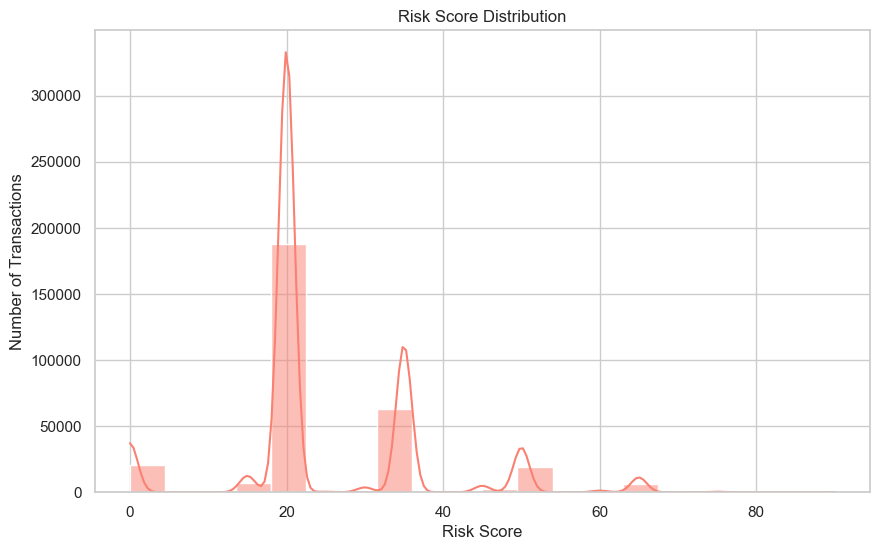

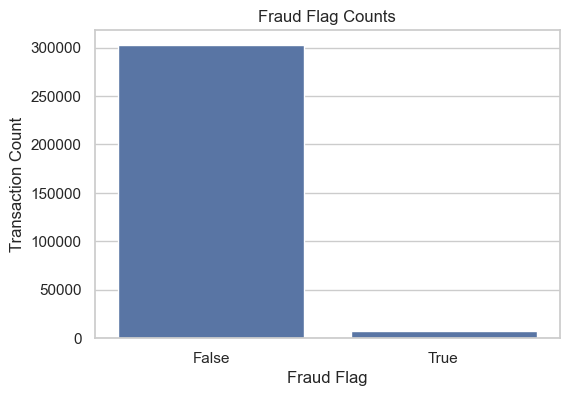

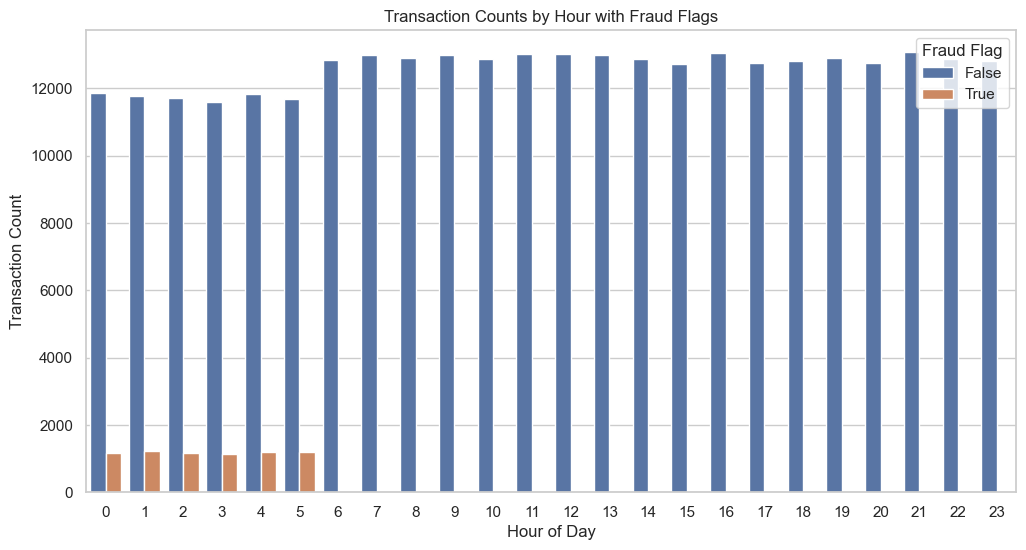

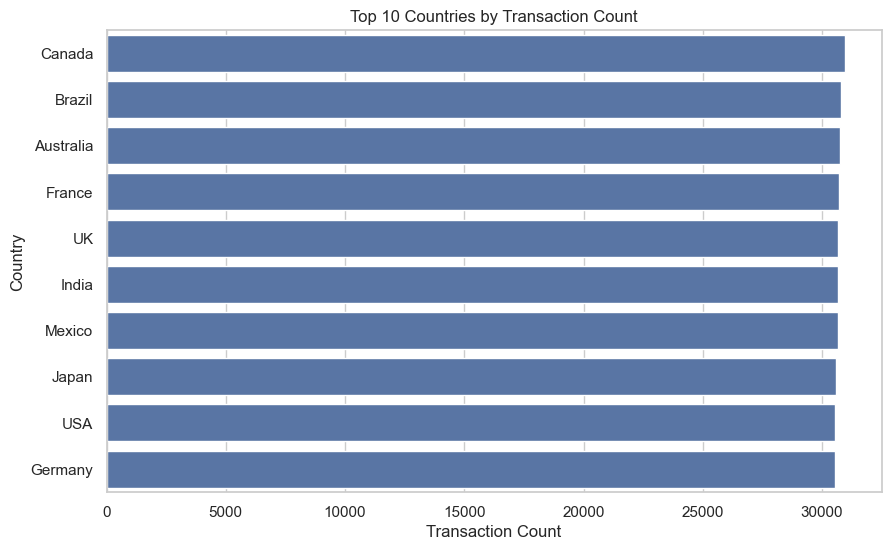

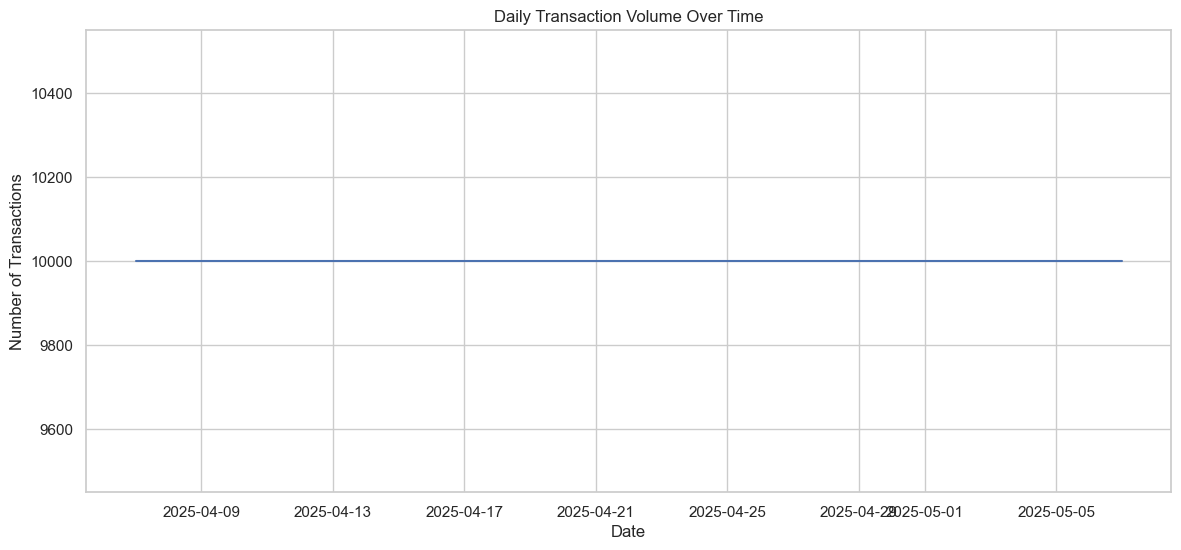

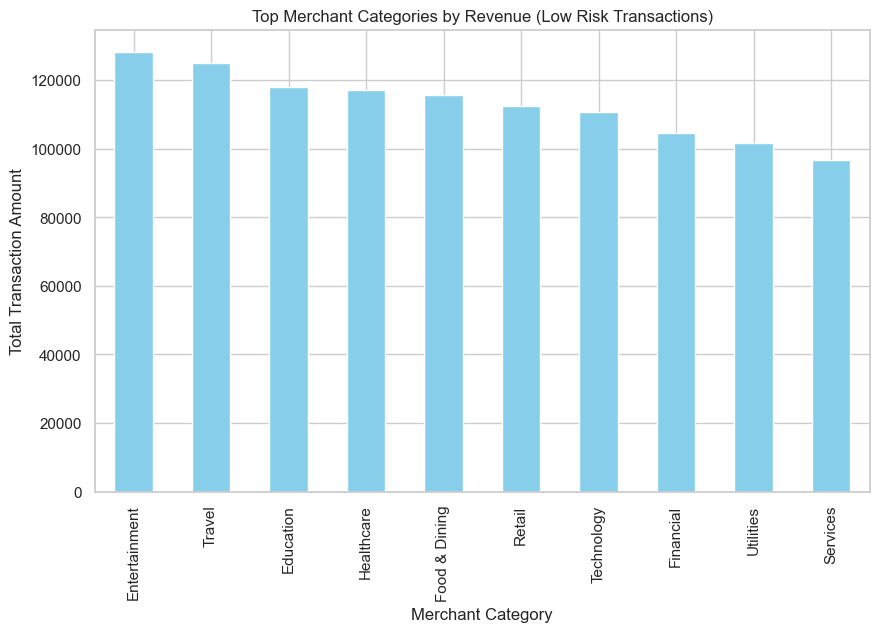

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directories
UPDATED_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data"

# List all processed files
files = [f for f in os.listdir(UPDATED_DIR) if f.endswith("_cleaned_level2.csv")]

# Function to sample data from large files without loading all into memory
def load_sampled_data(files, sample_size_per_file=10000):
    sampled_dfs = []
    for file in files:
        path = os.path.join(UPDATED_DIR, file)
        # Read sample rows (or all if file smaller)
        try:
            df_sample = pd.read_csv(path, nrows=sample_size_per_file)
            sampled_dfs.append(df_sample)
        except Exception as e:
            print(f"Skipped {file} due to error: {e}")
    combined_df = pd.concat(sampled_dfs, ignore_index=True)
    return combined_df

# Load combined sample dataframe
df = load_sampled_data(files)
print(f"Combined sample dataframe shape: {df.shape}")



# Convert hour to int if not already
df['hour'] = df['hour'].astype(int)

# Basic sanity checks for columns used in viz
print(df[['risk_score', 'fraud_flag', 'location_country', 'timestamp', 'hour']].info())


sns.set_style("whitegrid")

# 3.1 Risk Score Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['risk_score'], bins=20, kde=True, color="salmon")
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Transactions")
plt.show()

# 3.2 Fraud Flag Counts
plt.figure(figsize=(6,4))
sns.countplot(x='fraud_flag', data=df)
plt.title("Fraud Flag Counts")
plt.xlabel("Fraud Flag")
plt.ylabel("Transaction Count")
plt.show()

# 3.3 Transactions by Hour (with fraud flag hue)
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=df, hue='fraud_flag')
plt.title("Transaction Counts by Hour with Fraud Flags")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.legend(title='Fraud Flag')
plt.show()

# 3.4 Geographic Distribution (Top 10 Countries)
top_countries = df['location_country'].value_counts().nlargest(10).index
plt.figure(figsize=(10,6))
sns.countplot(y='location_country', data=df[df['location_country'].isin(top_countries)],
              order=top_countries)
plt.title("Top 10 Countries by Transaction Count")
plt.xlabel("Transaction Count")
plt.ylabel("Country")
plt.show()

# 3.5 Transaction Flow Over Time (Daily)
df['date'] = pd.to_datetime(df['timestamp']).dt.date
daily_txn_counts = df.groupby('date').size()

plt.figure(figsize=(14,6))
daily_txn_counts.plot()
plt.title("Daily Transaction Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()



# High transaction volume + low risk score segments
low_risk_df = df[df['risk_score'] < 20]

# Group by merchant category and sum amounts
merchant_revenue = low_risk_df.groupby('merchant_category')['amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
merchant_revenue.plot(kind='bar', color='skyblue')
plt.title("Top Merchant Categories by Revenue (Low Risk Transactions)")
plt.xlabel("Merchant Category")
plt.ylabel("Total Transaction Amount")
plt.show()
